In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [3]:
# import data

maxlon = 171

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = distance(Tok1)
Tok1 = Tok1[(Tok1['Lon']>130) & (Tok1['Lon']<maxlon)].dropna()

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = distance(Tok3)
Tok3 = Tok3[(Tok3['Lon']>130) & (Tok3['Lon']<maxlon)].dropna()

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = distance(Tian)
Tian = Tian[(Tian['Lon']>130) & (Tian['Lon']<maxlon)].dropna()

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density', u'dx', u'x'],
      dtype='object')


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


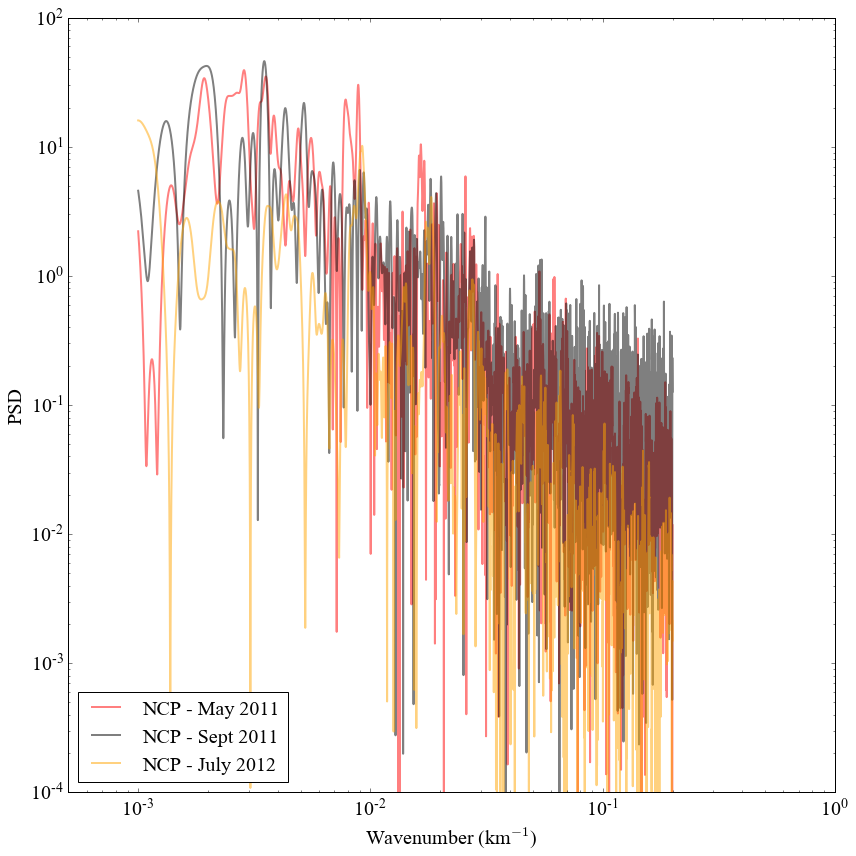

In [4]:
# Lomb-Scargle periodogram

nout = 100000 # number of frequency-space points at which to calculate the signal strength (output)
periods = np.linspace(5, 1000, nout)
freqs = 1.0 / periods
angular_freqs = 2 * np.pi * freqs

pgram = lombscargle(Tok1['x'].values, Tok1['Air-sea flux'].values-Tok1['Air-sea flux'].mean(), angular_freqs)
normalized_pgramTok1 = np.sqrt(4 * (pgram / len(Tok1['Air-sea flux'].values)))

pgram = lombscargle(Tok1['x'].values, Tok1['T'].values- Tok1['T'].mean(), angular_freqs)
normalized_pgramTok1T = np.sqrt(4 * (pgram / len(Tok1['T'].values)))

pgram = lombscargle(Tok3['x'].values, Tok3['Air-sea flux'].values- Tok3['Air-sea flux'].mean(), angular_freqs)
normalized_pgramTok3 = np.sqrt(4 * (pgram / len(Tok3['Air-sea flux'].values)))

pgram = lombscargle(Tok3['x'].values, Tok3['T'].values- Tok3['T'].mean(), angular_freqs)
normalized_pgramTok3T = np.sqrt(4 * (pgram / len(Tok3['T'].values)))

pgram = lombscargle(Tian['x'].values, Tian['Air-sea flux'].values, angular_freqs)
normalized_pgramTian = np.sqrt(4 * (pgram / len(Tian['Air-sea flux'].values)))

pgram = lombscargle(Tian['x'].values, Tian['T'].values- Tian['T'].mean(), angular_freqs)
normalized_pgramTianT = np.sqrt(4 * (pgram / len(Tian['T'].values)))

fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1/periods, normalized_pgramTok1**2, 'r', label = 'NCP - May 2011', lw = 2, alpha = 0.5)
#plt.loglog(1/periods, normalized_pgramTok1T**2, 'k', label = 'T - May 2011', lw = 2)

plt.loglog(1/periods, normalized_pgramTok3**2, 'k', label = 'NCP - Sept 2011', lw = 2, alpha = 0.5)
#plt.loglog(1/periods, normalized_pgramTok3T**2, 'grey', label = 'T - Sept 2011', lw = 2)

plt.loglog(1/periods, normalized_pgramTian**2, 'orange', label = 'NCP - July 2012', lw=2, alpha = 0.5)
#plt.loglog(1/periods, normalized_pgramTianT**2, 'grey', label = 'T - July 2012', lw=2)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axis([0.0005, 1, 0.0001, 100])

plt.show()

In [5]:
bins = 10**(np.arange(0,3,0.05))
bin_mid = bins[:(len(bins)-1)] + np.diff(bins)/2

binnedT1 = bin(normalized_pgramTok1, periods, bins, bin_mid)
binnedT3 = bin(normalized_pgramTok3, periods, bins, bin_mid)
binnedTian = bin(normalized_pgramTian, periods, bins, bin_mid)

binnedT1T = bin(normalized_pgramTok1T, periods, bins, bin_mid)
binnedT3T = bin(normalized_pgramTok3T, periods, bins, bin_mid)
binnedTianT = bin(normalized_pgramTianT, periods, bins, bin_mid)

/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


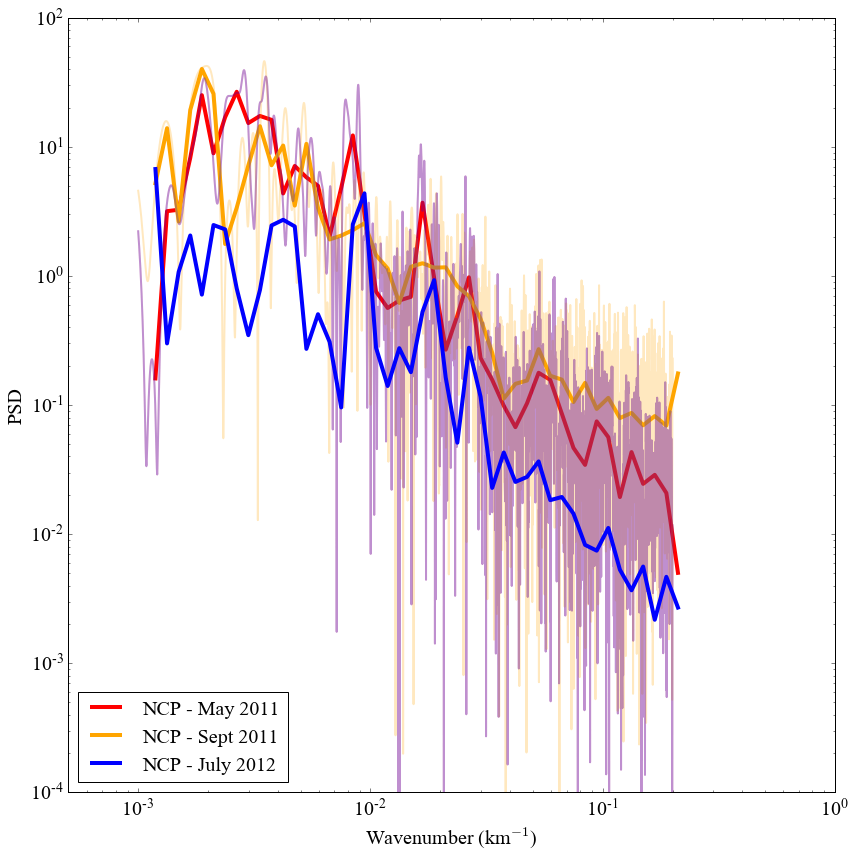

In [6]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1/periods, normalized_pgramTok1**2, 'r', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedT1['k_mid'].values), binnedT1['var'].values**2, 'r', label = 'NCP - May 2011', lw = 4)

plt.loglog(1/periods, normalized_pgramTok3**2, 'orange', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedT3['k_mid'].values), binnedT3['var'].values**2, 'orange', label = 'NCP - Sept 2011', lw = 4)

plt.loglog(1/periods, normalized_pgramTok1**2, 'b', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedTian['k_mid'].values), binnedTian['var'].values**2, 'b', label = 'NCP - July 2012', lw = 4)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axis([0.0005, 1, 0.0001, 100])

plt.show()

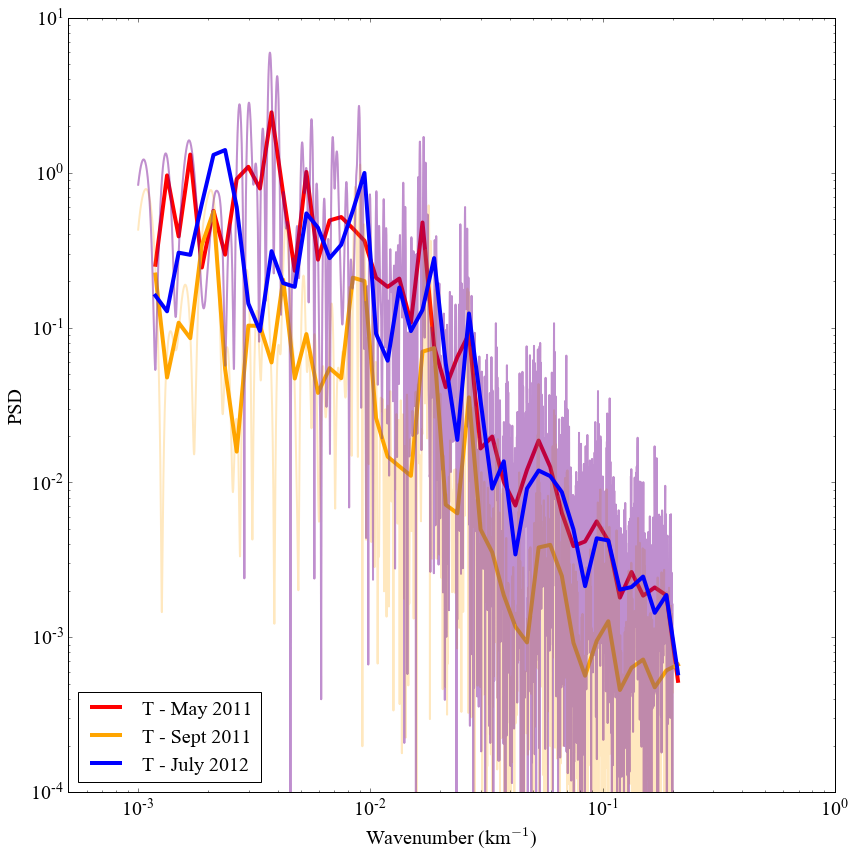

In [7]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1/periods, normalized_pgramTok1T**2, 'r', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedT1T['k_mid'].values), binnedT1T['var'].values**2, 'r', label = 'T - May 2011', lw = 4)

plt.loglog(1/periods, normalized_pgramTok3T**2, 'orange', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedT3T['k_mid'].values), binnedT3T['var'].values**2, 'orange', label = 'T - Sept 2011', lw = 4)

plt.loglog(1/periods, normalized_pgramTok1T**2, 'b', lw = 2, alpha = 0.25)
plt.loglog(1./(binnedTianT['k_mid'].values), binnedTianT['var'].values**2, 'b', label = 'T - July 2012', lw = 4)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axis([0.0005, 1, 0.0001, 10])

plt.show()

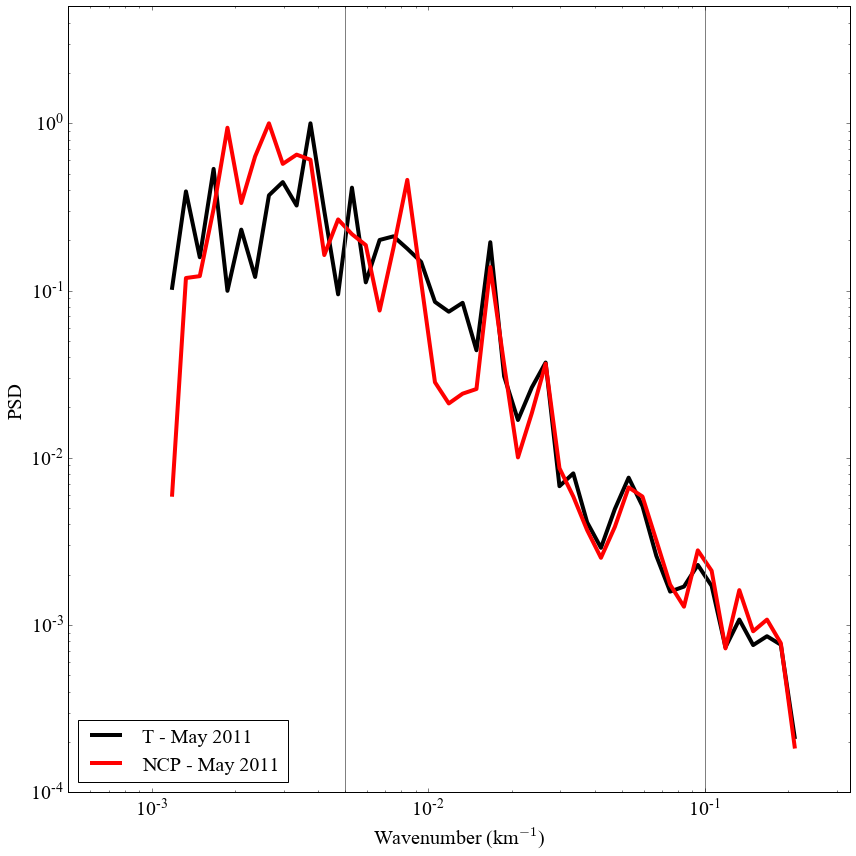

In [8]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
plt.loglog(1./(binnedT1T['k_mid'].values), (binnedT1T['var'].values/binnedT1T['var'].max())**2, 'k', label = 'T - May 2011', lw = 4)
plt.loglog(1./(binnedT1['k_mid'].values), (binnedT1['var'].values/binnedT1['var'].max())**2, 'r', label = 'NCP - May 2011', lw = 4)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()

fig1.savefig('../figures/T_NCP_spectra_May11.png', bbox_inches='tight', dpi=600)

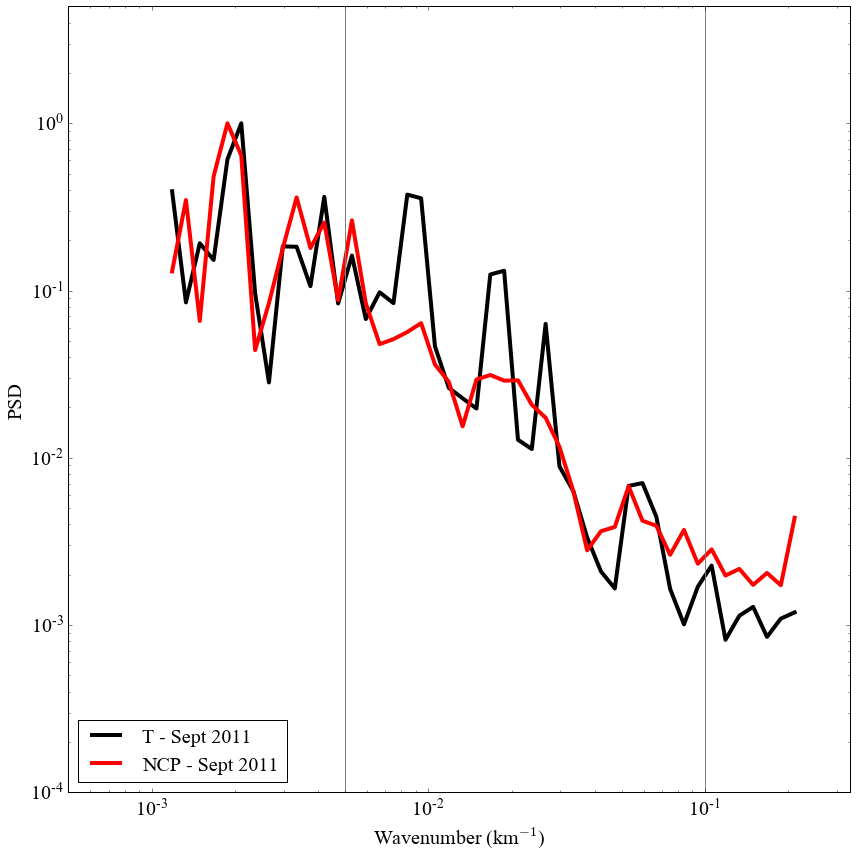

In [9]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
#plt.loglog(1/periods, normalized_pgramTok1T**2, 'r', lw = 2, alpha = 0.25)
#plt.loglog(1./(binnedT1T['k_mid'].values), binnedT1T['var'].values**2, 'grey', label = 'T - May 2011', lw = 4)

plt.loglog(1./(binnedT3T['k_mid'].values), (binnedT3T['var'].values/binnedT3T['var'].max())**2, 'k', label = 'T - Sept 2011', lw = 4)
plt.loglog(1./(binnedT3['k_mid'].values), (binnedT3['var'].values/binnedT3['var'].max())**2, 'r', label = 'NCP - Sept 2011', lw = 4)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()

fig1.savefig('../figures/T_NCP_spectra_September11.png', bbox_inches='tight', dpi=600)

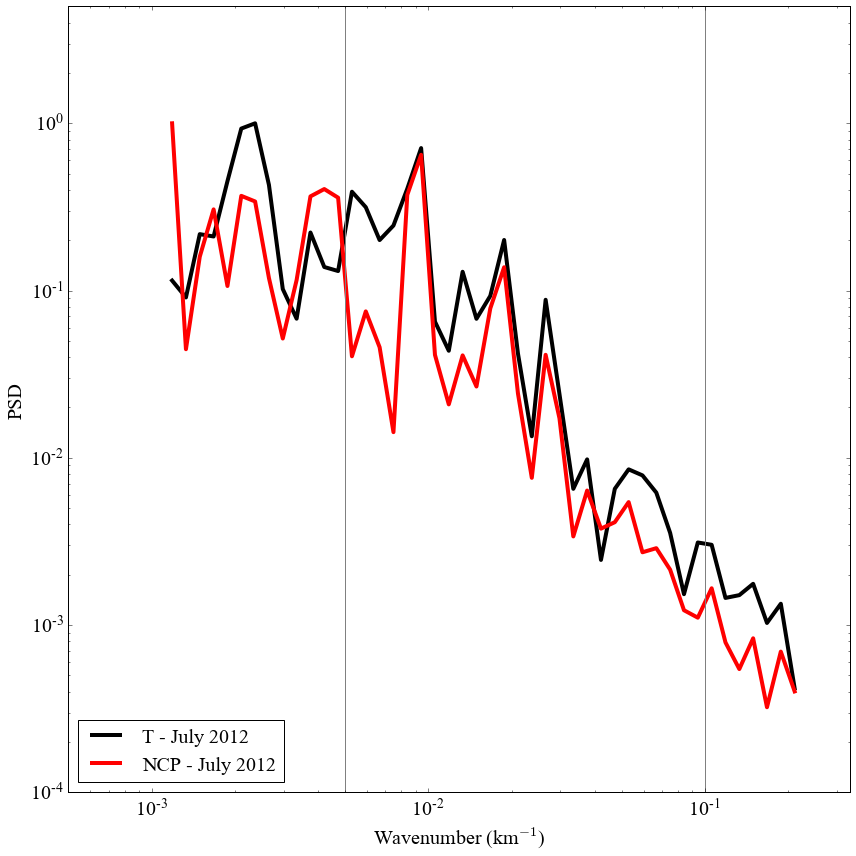

In [10]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.loglog(1./(binnedTianT['k_mid'].values), (binnedTianT['var'].values/binnedTianT['var'].max())**2, 'k', label = 'T - July 2012', lw = 4)
plt.loglog(1./(binnedTian['k_mid'].values), (binnedTian['var'].values/binnedTian['var'].max())**2, 'r', label = 'NCP - July 2012', lw = 4)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()

fig1.savefig('../figures/T_NCP_spectra_July12.png', bbox_inches='tight', dpi=600)

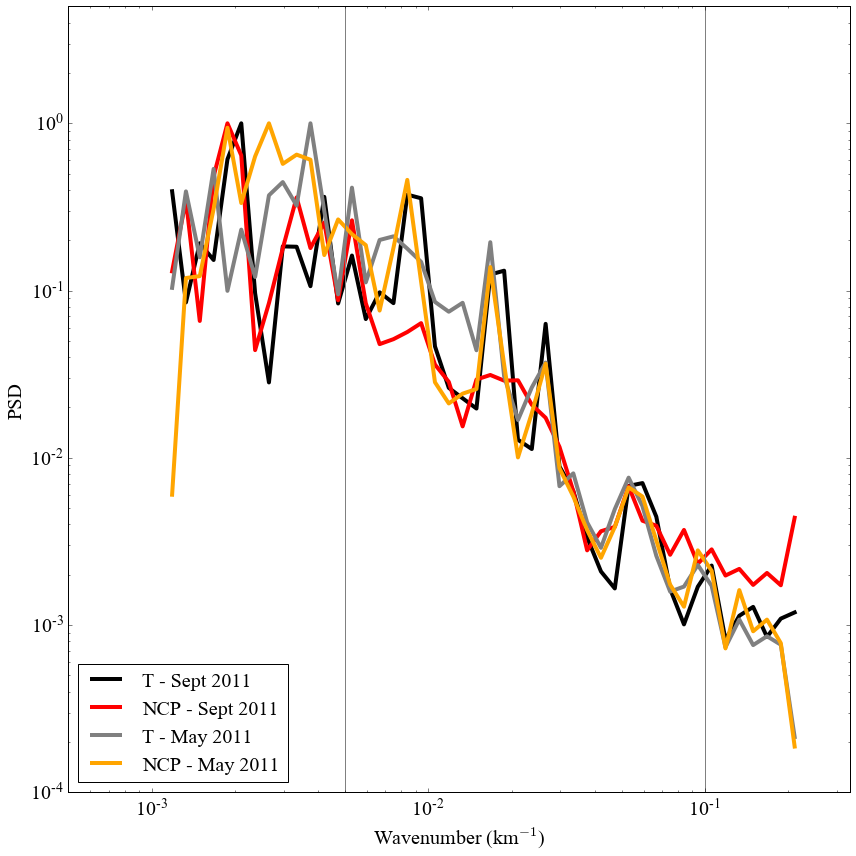

In [11]:
fig1 = plt.figure(3, figsize=(12,12), dpi = 600)
#plt.loglog(1/periods, normalized_pgramTok1T**2, 'r', lw = 2, alpha = 0.25)
#plt.loglog(1./(binnedT1T['k_mid'].values), binnedT1T['var'].values**2, 'grey', label = 'T - May 2011', lw = 4)

plt.loglog(1./(binnedT3T['k_mid'].values), (binnedT3T['var'].values/binnedT3T['var'].max())**2, 'k', label = 'T - Sept 2011', lw = 4)
plt.loglog(1./(binnedT3['k_mid'].values), (binnedT3['var'].values/binnedT3['var'].max())**2, 'r', label = 'NCP - Sept 2011', lw = 4)

plt.loglog(1./(binnedT1T['k_mid'].values), (binnedT1T['var'].values/binnedT1T['var'].max())**2, 'grey', label = 'T - May 2011', lw = 4)
plt.loglog(1./(binnedT1['k_mid'].values), (binnedT1['var'].values/binnedT1['var'].max())**2, 'orange', label = 'NCP - May 2011', lw = 4)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavenumber (km$^{-1}$)', fontsize = 20)

plt.axvline(1./200, color = 'grey')
plt.axvline(1./10, color = 'grey')

plt.axis([0.0005, 1./3, 0.0001, 5])

plt.show()